# Vision -> Contour -> RoboDK notebook
Run cells in order. Editable config is below.

Outputs:
- `results/vision_results_<TIMESTAMP>.csv` (detailed per-run values)
- displayed DataFrame and copy-pasteable table

If you want to compute **Mapping RMS (image → robot)**, create two CSV files in `calib/`:
- `calib/robot_points.csv` — columns: x,y,z  (units: mm)
- `calib/image_points.csv` — columns: x,y  (pixel coordinates in the image used for calibration)

These must have the same number of rows and matching correspondences.


In [16]:
# Cell 1: imports and config
import os
import time
import csv
import math
import logging
from datetime import datetime
from pathlib import Path

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Try importing RoboDK libraries; if unavailable, notebook will simulate RoboDK step
try:
    from robolink import Robolink, ITEM_TYPE_ROBOT, ITEM_TYPE_FRAME, ITEM_TYPE_TARGET, TargetReachError
    from robodk import transl
    RDK_AVAILABLE = True
except Exception as e:
    RDK_AVAILABLE = False
    # create dummy names for exceptions
    class TargetReachError(Exception):
        pass

# Logging
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')
log = logging.getLogger("vision_notebook")

# Directories
ROOT = Path('python/measurments.ipynb').parent
DATA_DIR = Path("../data")
RESULTS_DIR = Path('../data/results')
CALIB_DIR = Path("../calib")

for d in (DATA_DIR, RESULTS_DIR, CALIB_DIR):
    d.mkdir(parents=True, exist_ok=True)

# CONFIG 
IMAGE_PATH = DATA_DIR / "webcam_capture.png"   # saved capture or existing image
TABLE_FRAME_NAME = "table"
DRAW_POSITION_NAME = "DrawBase"
ROBOT_NAME = "Motoman HP6"
DRAW_AREA_MM = 220
Z_DRAW = 50
POINT_STEP = 2 # been experimenting with 5, it seems to be too large simplification
CAM_INDEX = 0

# Repeatability captures
REPEATABILITY_N = 10  # number of captures for pixel jitter measurement

# RDP parameter relative to perimeter (tweak as needed)
RDP_EPSILON_RATIO = 0.01

# Show images inline
%matplotlib inline


In [8]:
# Cell 2: utility functions

def capture_from_webcam(out_path, cam_index=0, settle_frames=5, show=False):
    """Capture a single frame from webcam and save it to out_path.
    Returns the BGR image (numpy array)."""
    cap = cv2.VideoCapture(cam_index)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open webcam with index {cam_index}")

    # let camera auto-exposure settle
    for _ in range(settle_frames):
        ret, frame = cap.read()
        if not ret:
            cap.release()
            raise RuntimeError("Failed to read frame from webcam during settling")

    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise RuntimeError("Failed to capture final frame from webcam")

    cv2.imwrite(str(out_path), frame)
    log.info(f"Saved webcam frame to: {out_path}")

    if show:
        plt.figure(figsize=(6,6))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title("Captured webcam frame")
        plt.axis('off')
        plt.show()

    return frame


def load_main_contour(path, point_step=POINT_STEP, show=False, rdp_ratio=RDP_EPSILON_RATIO):
    """Load image, threshold -> find largest contour (CHAIN_APPROX_NONE) -> subsample -> simplify.
    Returns:
      raw_contour (N,2), simplified_contour (M,2), original_image (BGR), mask
    """
    img = cv2.imread(str(path))
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)

    # Otsu adaptive threshold for dark object on light background
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise ValueError("No contours found in image")

    cnt = max(contours, key=cv2.contourArea)
    raw = cnt.squeeze()  # Nx2

    # If contour is degenerate (single point), handle
    if raw.ndim != 2 or raw.shape[0] < 3:
        raise ValueError("Found contour but it is too small or degenerate")

    # Subsample
    raw_sub = raw[::point_step]

    # RDP simplification
    perimeter = cv2.arcLength(cnt, True)
    eps = float(rdp_ratio) * perimeter
    approx = cv2.approxPolyDP(cnt, eps, True).squeeze()
    if approx.ndim != 2:
        approx = approx.reshape(-1,2)

    # optionally show
    if show:
        fig, axs = plt.subplots(1,3, figsize=(12,4))
        axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Original")
        axs[0].axis('off')

        axs[1].imshow(thresh, cmap='gray')
        axs[1].set_title("Threshold mask")
        axs[1].axis('off')

        axs[2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[2].plot(raw[:,0], raw[:,1], linewidth=0.5, label='raw (all)')
        axs[2].plot(raw_sub[:,0], raw_sub[:,1], '.', label='subsampled')
        axs[2].plot(approx[:,0], approx[:,1], '-o', linewidth=1.5, label='simplified')
        axs[2].set_title("Contours")
        axs[2].legend()
        axs[2].invert_yaxis()  # show like image coords
        plt.show()

    return raw, raw_sub, approx, img, thresh


def pixel_to_table_mm(points_px, img_size, draw_area_mm=DRAW_AREA_MM):
    """Map pixel coordinates (Nx2) to table coords in mm centered at 0,0."""
    h, w = img_size
    xs = points_px[:,0].astype(np.float32)
    ys = points_px[:,1].astype(np.float32)

    xmin, xmax = xs.min(), xs.max()
    ymin, ymax = ys.min(), ys.max()

    xs_norm = (xs - xmin) / (xmax - xmin + 1e-9)
    ys_norm = (ys - ymin) / (ymax - ymin + 1e-9)

    L = float(draw_area_mm)
    xs_mm = (xs_norm - 0.5) * L
    ys_mm = (0.5 - ys_norm) * L  # invert y

    return np.stack([xs_mm, ys_mm], axis=1)


def compute_rms_mapping(robot_points_np, image_points_px_np, transform_func):
    """Given arrays of robot true points (Nx3) and image points (Nx2),
    compute mapped robot estimates via transform_func(image_px) -> (x,y,z)
    and return RMS in mm.
    transform_func must accept Nx2 array and return Nx3 array.
    """
    est = transform_func(image_points_px_np)
    diffs = robot_points_np - est
    dists = np.linalg.norm(diffs, axis=1)
    rms = np.sqrt(np.mean(dists**2))
    return rms, dists


def load_calib_csvs(calib_dir=CALIB_DIR):
    """Try to load calib/robot_points.csv and calib/image_points.csv.
    Return numpy arrays or None if files missing."""
    robot_f = calib_dir / "robot_points.csv"
    image_f = calib_dir / "image_points.csv"
    if robot_f.exists() and image_f.exists():
        robot = np.loadtxt(robot_f, delimiter=",")
        image = np.loadtxt(image_f, delimiter=",")
        if robot.ndim == 1:
            robot = robot.reshape(1, -1)
        if image.ndim == 1:
            image = image.reshape(1, -1)
        if robot.shape[0] != image.shape[0]:
            raise ValueError("Calibration CSVs have different row counts")
        return robot, image
    else:
        return None, None


def estimate_homography_and_map(image_points_px, robot_points_xyz):
    """Given correspondences, compute planar homography mapping X,Y pixels -> X,Y mm.
    robot_points_xyz is Nx3. We assume Z is constant and return a function mapping px->xyz (z from robot_points).
    This is a simple least-squares homography on (u,v) -> (X_mm,Y_mm).
    """
    # use only X,Y of robot points
    src = image_points_px.astype(np.float32)
    dst = robot_points_xyz[:, :2].astype(np.float32)

    if src.shape[0] < 4:
        log.warning("Less than 4 points: using affine or linear fit for mapping")
        # fallback to affine: solve dst = A * [u v 1]^T
        A, _, _, _ = np.linalg.lstsq(
            np.hstack([src, np.ones((src.shape[0],1))]),
            dst,
            rcond=None
        )
        def map_func(pts_px):
            pts = np.asarray(pts_px, dtype=np.float32)
            if pts.ndim==1:
                pts = pts.reshape(1,-1)
            out_xy = np.dot(np.hstack([pts, np.ones((pts.shape[0],1))]), A)
            z = np.full((out_xy.shape[0],1), robot_points_xyz[0,2])
            return np.hstack([out_xy, z])
        return map_func

    H, _ = cv2.findHomography(src, dst, method=0)
    def map_func(pts_px):
        pts = np.asarray(pts_px, dtype=np.float32).reshape(-1,2)
        pts_h = cv2.convertPointsToHomogeneous(pts)[:,0,:]  # Nx3
        mapped = (H @ pts_h.T).T  # Nx3 (homogeneous)
        mapped_xy = (mapped[:, :2].T / mapped[:, 2]).T
        z = np.full((mapped_xy.shape[0],1), robot_points_xyz[0,2])
        return np.hstack([mapped_xy, z])
    return map_func


def generate_robot_targets_sim(simplified_mm):
    """Simulate target generation time cost. Returns time_ms and number of targets created."""
    t0 = time.perf_counter()
    # simulate some processing per target
    for _ in simplified_mm:
        time.sleep(0.001)  # 1 ms per target fake
    t1 = time.perf_counter()
    return (t1 - t0)*1000.0, len(simplified_mm)

In [9]:
# Cell 3: pipeline runner and logger

def run_single_pipeline(image_path=IMAGE_PATH, do_capture=False, show_images=False, rdp_ratio=RDP_EPSILON_RATIO,
                        measure_repeatability=False, repeat_n=REPEATABILITY_N, save_results=True, simulate_robo_if_missing=True):
    """
    Runs entire pipeline for a single image (or capture).
    Returns a dict of metrics and saves a CSV row.
    """
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    metrics = {
        "timestamp": ts,
        "image_path": str(image_path),
        "point_step": POINT_STEP,
        "rdp_ratio": rdp_ratio,
        "draw_area_mm": DRAW_AREA_MM,
        "pc_spec": "USER_FILL",  # please replace with actual PC spec in final report
    }

    # optional capture
    if do_capture:
        capture_from_webcam(image_path, CAM_INDEX, show=show_images)

    # Vision processing timing
    t0 = time.perf_counter()
    raw, raw_sub, approx, img, mask = load_main_contour(image_path, point_step=POINT_STEP, show=show_images, rdp_ratio=rdp_ratio)
    t1 = time.perf_counter()
    vision_ms = (t1 - t0) * 1000.0

    metrics.update({
        "n_raw_points": int(raw.shape[0]),
        "n_subsampled": int(raw_sub.shape[0]),
        "n_simplified": int(approx.shape[0]),
        "vision_ms": float(vision_ms)
    })

    # Map pixels -> mm
    img_size = img.shape[:2]
    # Use approx for mapping so that mapping uses same points as robot targets
    simplified_px = approx
    simplified_mm = pixel_to_table_mm(simplified_px, img_size, DRAW_AREA_MM)

    # Try loading calibration CSVs
    robot_calib, image_calib = load_calib_csvs()
    if robot_calib is not None:
        try:
            map_func = estimate_homography_and_map(image_calib, robot_calib)
            # compute RMS over calib correspondences to sanity-check
            rms_calib, dists_calib = compute_rms_mapping(robot_calib, image_calib, map_func)
            metrics["mapping_rms_calib_mm"] = float(rms_calib)
            metrics["mapping_rms_calib_max_mm"] = float(np.max(dists_calib))
            log.info(f"Calibration RMS (from CSVs): {rms_calib:.3f} mm")
        except Exception as e:
            log.warning(f"Failed computing mapping from calibration CSVs: {e}")
            metrics["mapping_rms_calib_mm"] = np.nan
    else:
        metrics["mapping_rms_calib_mm"] = np.nan
        log.info("Calibration files not found in calib/. Skipping mapping RMS computation via CSVs.")

    # Robot target generation timing (try RoboDK if available)
    if RDK_AVAILABLE:
        try:
            t0 = time.perf_counter()
            RDK = Robolink()
            robot = RDK.Item(ROBOT_NAME, ITEM_TYPE_ROBOT)
            frame = RDK.Item(TABLE_FRAME_NAME, ITEM_TYPE_FRAME)
            base_target = RDK.Item(DRAW_POSITION_NAME, ITEM_TYPE_TARGET)
            if not robot.Valid() or not frame.Valid() or not base_target.Valid():
                raise RuntimeError("RoboDK items not found or invalid. Falling back to simulated target generation.")
            # produce targets in RoboDK - measure time
            created = 0
            for xy in simplified_mm:
                px, py = float(xy[0]), float(xy[1])
                pose = base_target.Pose() * transl(px, py, 0.0)
                # Add a temporary target (it will remain in station)
                RDK.AddTarget(f"TMP_{metrics['timestamp']}_{created}")
                created += 1
            t1 = time.perf_counter()
            robot_gen_ms = (t1 - t0) * 1000.0
            metrics["robot_gen_ms"] = float(robot_gen_ms)
            metrics["robot_targets_created"] = created
            log.info(f"RoboDK: created {created} targets in {robot_gen_ms:.1f} ms")
        except Exception as e:
            log.warning(f"RoboDK generation failed: {e}")
            robot_gen_ms, created = generate_robot_targets_sim(simplified_mm)
            metrics["robot_gen_ms"] = float(robot_gen_ms)
            metrics["robot_targets_created"] = int(created)
            metrics["robo_simulated"] = True
    else:
        robot_gen_ms, created = generate_robot_targets_sim(simplified_mm)
        metrics["robot_gen_ms"] = float(robot_gen_ms)
        metrics["robot_targets_created"] = int(created)
        metrics["robo_simulated"] = True
        log.info(f"RoboDK not available: simulated generation time {robot_gen_ms:.1f} ms")

    # Mapping RMS for a set of validation points: if calibration exists, use it to estimate mapping for drawn shape:
    # We'll compute RMS between mapped simplified points and optionally provided robot-sensor correspondences if you provide
    # a 'validation' pair list in calib/validation_robot.csv and calib/validation_image.csv
    val_robot, val_image = None, None
    val_robot_f = CALIB_DIR / "validation_robot.csv"
    val_image_f = CALIB_DIR / "validation_image.csv"
    if val_robot_f.exists() and val_image_f.exists():
        val_robot = np.loadtxt(val_robot_f, delimiter=",")
        val_image = np.loadtxt(val_image_f, delimiter=",")
        if val_robot.ndim==1:
            val_robot = val_robot.reshape(1,-1)
        if val_image.ndim==1:
            val_image = val_image.reshape(1,-1)
        if robot_calib is not None:
            map_func = estimate_homography_and_map(image_calib, robot_calib)
            try:
                rms_val, dists_val = compute_rms_mapping(val_robot, val_image, map_func)
                metrics["mapping_rms_validation_mm"] = float(rms_val)
                metrics["mapping_rms_validation_max_mm"] = float(np.max(dists_val))
                log.info(f"Validation RMS: {rms_val:.3f} mm")
            except Exception as e:
                log.warning(f"Failed mapping validation points: {e}")
                metrics["mapping_rms_validation_mm"] = np.nan
        else:
            metrics["mapping_rms_validation_mm"] = np.nan
            log.info("Validation files present but no calibration mapping available.")
    else:
        metrics["mapping_rms_validation_mm"] = np.nan

    # Repeatability measurement (pixel jitter)
    if measure_repeatability:
        centers = []
        for i in range(repeat_n):
            # capture quickly and compute centroid of largest contour
            tmp_img = capture_from_webcam(DATA_DIR / f"repeat_{i}.png", cam_index=CAM_INDEX, settle_frames=3, show=False)
            try:
                raw2, raw_sub2, approx2, _, _ = load_main_contour(DATA_DIR / f"repeat_{i}.png", point_step=POINT_STEP, show=False, rdp_ratio=rdp_ratio)
                # centroid of raw_sub or approx
                c = np.mean(approx2, axis=0)
                centers.append(c)
            except Exception as e:
                log.warning(f"Repeat capture {i} failed to find contour: {e}")

        centers = np.array(centers)
        if centers.shape[0] >= 2:
            mean_c = np.mean(centers, axis=0)
            dists = np.linalg.norm(centers - mean_c, axis=1)
            metrics["repeat_mean_px"] = float(np.mean(dists))
            metrics["repeat_std_px"] = float(np.std(dists))
            log.info(f"Repeatability (px): {metrics['repeat_mean_px']:.3f} ± {metrics['repeat_std_px']:.3f}")
        else:
            metrics["repeat_mean_px"] = np.nan
            metrics["repeat_std_px"] = np.nan
            log.warning("Not enough successful repeat captures to compute repeatability.")
    else:
        metrics["repeat_mean_px"] = np.nan
        metrics["repeat_std_px"] = np.nan

    # Save some debug artifacts (overlay plot)
    try:
        fig, ax = plt.subplots(figsize=(6,6))
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.plot(raw[:,0], raw[:,1], linewidth=0.5, label='raw')
        ax.scatter(raw_sub[:,0], raw_sub[:,1], s=8, label='subsampled')
        ax.plot(approx[:,0], approx[:,1], '-o', linewidth=1.2, label='simplified')
        ax.set_title(f"Contour overlay - {metrics['timestamp']}")
        ax.axis('off')
        ax.invert_yaxis()
        overlay_path = RESULTS_DIR / f"overlay_{metrics['timestamp']}.png"
        fig.savefig(overlay_path, dpi=200, bbox_inches='tight')
        plt.show()
        metrics["overlay_image"] = str(overlay_path)
    except Exception as e:
        log.warning(f"Failed to create overlay plot: {e}")
        metrics["overlay_image"] = ""

    # Persist metrics row
    if save_results:
        df_row = pd.DataFrame([metrics])
        out_path = RESULTS_DIR / f"vision_results_{metrics['timestamp']}.csv"
        df_row.to_csv(out_path, index=False)
        log.info(f"Saved results to {out_path}")
        metrics["results_file"] = str(out_path)

    return metrics


[INFO] Saved webcam frame to: ..\data\webcam_capture.png


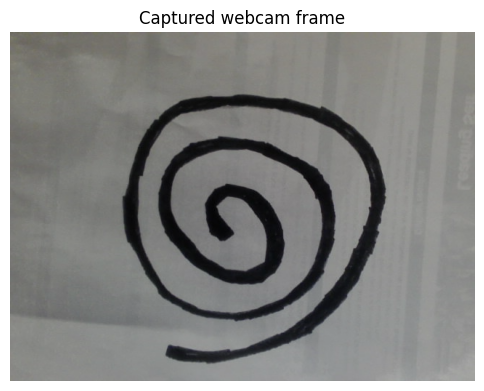

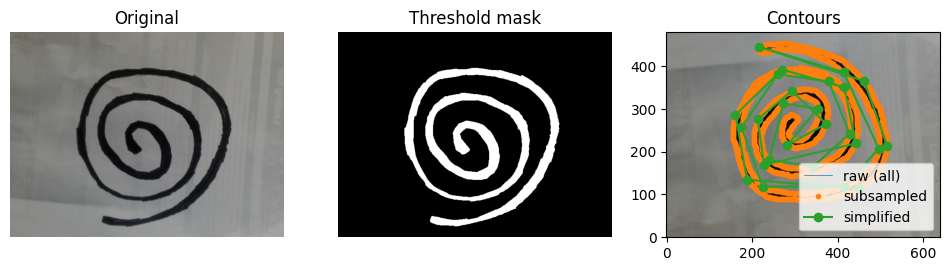

[INFO] Calibration files not found in calib/. Skipping mapping RMS computation via CSVs.
[INFO] RoboDK: created 26 targets in 791.3 ms
[INFO] Saved webcam frame to: ..\data\repeat_0.png
[INFO] Saved webcam frame to: ..\data\repeat_1.png
[INFO] Saved webcam frame to: ..\data\repeat_2.png
[INFO] Saved webcam frame to: ..\data\repeat_3.png
[INFO] Saved webcam frame to: ..\data\repeat_4.png
[INFO] Saved webcam frame to: ..\data\repeat_5.png
[INFO] Saved webcam frame to: ..\data\repeat_6.png
[INFO] Saved webcam frame to: ..\data\repeat_7.png
[INFO] Saved webcam frame to: ..\data\repeat_8.png
[INFO] Saved webcam frame to: ..\data\repeat_9.png
[INFO] Repeatability (px): 5.067 ± 2.287


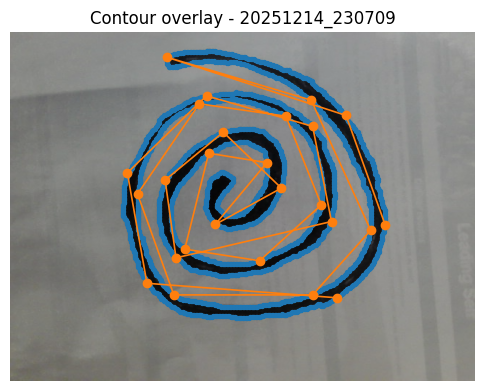

[INFO] Saved results to ..\data\results\vision_results_20251214_230709.csv


{'timestamp': '20251214_230709',
 'image_path': '..\\data\\webcam_capture.png',
 'point_step': 2,
 'rdp_ratio': 0.01,
 'draw_area_mm': 220,
 'pc_spec': 'USER_FILL',
 'n_raw_points': 3895,
 'n_subsampled': 1948,
 'n_simplified': 26,
 'vision_ms': 290.2849999954924,
 'mapping_rms_calib_mm': nan,
 'robot_gen_ms': 791.3069999776781,
 'robot_targets_created': 26,
 'mapping_rms_validation_mm': nan,
 'repeat_mean_px': 5.067489137398441,
 'repeat_std_px': 2.2870172442403987,
 'overlay_image': '..\\data\\results\\overlay_20251214_230709.png',
 'results_file': '..\\data\\results\\vision_results_20251214_230709.csv'}

In [17]:
# Cell 4: run the pipeline on an existing image (or set do_capture=True)
# Edit options as required

metrics = run_single_pipeline(image_path=IMAGE_PATH,
                              do_capture=True,   # set True to use webcam capture instead of an existing file
                              show_images=True,   # display images inline
                              rdp_ratio=RDP_EPSILON_RATIO,
                              measure_repeatability=True,  # set True to run REPEATABILITY_N webcam captures (slow)
                              repeat_n=REPEATABILITY_N,
                              save_results=True)
metrics

[INFO] Saved webcam frame to: ..\data\webcam_capture.png


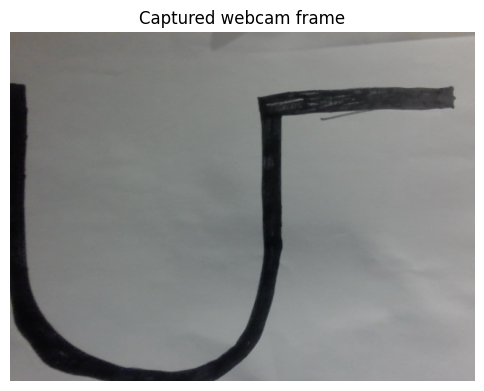

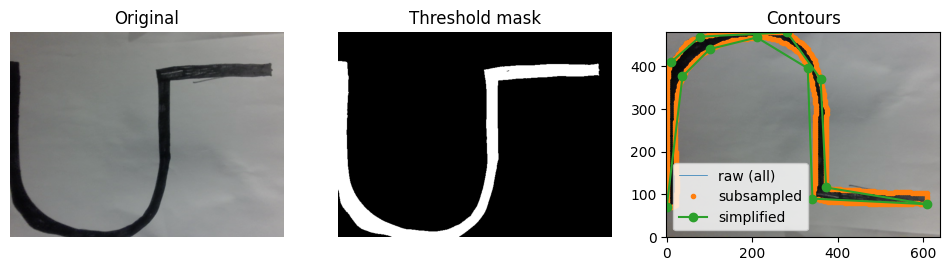

[INFO] Calibration files not found in calib/. Skipping mapping RMS computation via CSVs.
[INFO] RoboDK: created 12 targets in 371.7 ms
[INFO] Saved webcam frame to: ..\data\repeat_0.png
[INFO] Saved webcam frame to: ..\data\repeat_1.png
[INFO] Saved webcam frame to: ..\data\repeat_2.png
[INFO] Saved webcam frame to: ..\data\repeat_3.png
[INFO] Saved webcam frame to: ..\data\repeat_4.png
[INFO] Saved webcam frame to: ..\data\repeat_5.png
[INFO] Saved webcam frame to: ..\data\repeat_6.png
[INFO] Saved webcam frame to: ..\data\repeat_7.png
[INFO] Saved webcam frame to: ..\data\repeat_8.png
[INFO] Saved webcam frame to: ..\data\repeat_9.png
[INFO] Repeatability (px): 13.654 ± 5.866


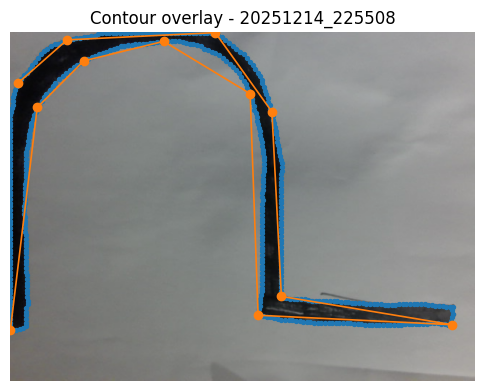

[INFO] Saved results to ..\data\results\vision_results_20251214_225508.csv


{'timestamp': '20251214_225508',
 'image_path': '..\\data\\webcam_capture.png',
 'point_step': 5,
 'rdp_ratio': 0.01,
 'draw_area_mm': 220,
 'pc_spec': 'USER_FILL',
 'n_raw_points': 2468,
 'n_subsampled': 494,
 'n_simplified': 12,
 'vision_ms': 206.301300029736,
 'mapping_rms_calib_mm': nan,
 'robot_gen_ms': 371.728099999018,
 'robot_targets_created': 12,
 'mapping_rms_validation_mm': nan,
 'repeat_mean_px': 13.653748372874494,
 'repeat_std_px': 5.865940345044218,
 'overlay_image': '..\\data\\results\\overlay_20251214_225508.png',
 'results_file': '..\\data\\results\\vision_results_20251214_225508.csv'}

In [14]:
metrics = run_single_pipeline(image_path=IMAGE_PATH,
                              do_capture=True,   # set True to use webcam capture instead of an existing file
                              show_images=True,   # display images inline
                              rdp_ratio=RDP_EPSILON_RATIO,
                              measure_repeatability=True,  # set True to run REPEATABILITY_N webcam captures (slow)
                              repeat_n=REPEATABILITY_N,
                              save_results=True)
metrics

[INFO] Saved webcam frame to: ..\data\webcam_capture.png


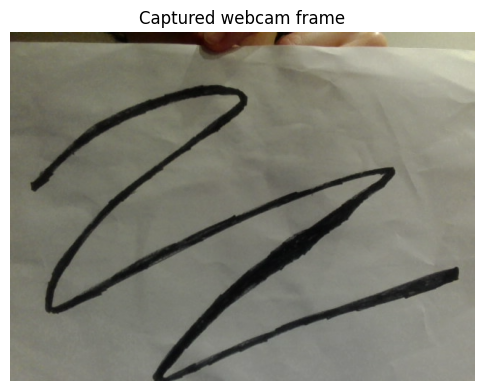

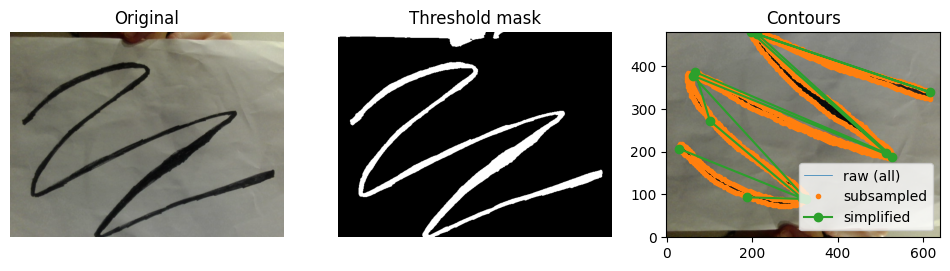

[INFO] Calibration files not found in calib/. Skipping mapping RMS computation via CSVs.
[INFO] RoboDK: created 12 targets in 394.5 ms
[INFO] Saved webcam frame to: ..\data\repeat_0.png
[INFO] Saved webcam frame to: ..\data\repeat_1.png
[INFO] Saved webcam frame to: ..\data\repeat_2.png
[INFO] Saved webcam frame to: ..\data\repeat_3.png
[INFO] Saved webcam frame to: ..\data\repeat_4.png
[INFO] Saved webcam frame to: ..\data\repeat_5.png
[INFO] Saved webcam frame to: ..\data\repeat_6.png
[INFO] Saved webcam frame to: ..\data\repeat_7.png
[INFO] Saved webcam frame to: ..\data\repeat_8.png
[INFO] Saved webcam frame to: ..\data\repeat_9.png
[INFO] Repeatability (px): 5.179 ± 4.872


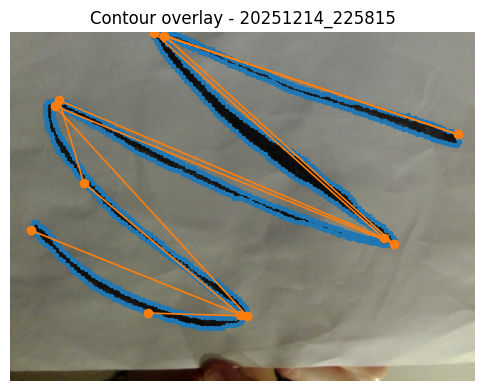

[INFO] Saved results to ..\data\results\vision_results_20251214_225815.csv


{'timestamp': '20251214_225815',
 'image_path': '..\\data\\webcam_capture.png',
 'point_step': 5,
 'rdp_ratio': 0.01,
 'draw_area_mm': 220,
 'pc_spec': 'USER_FILL',
 'n_raw_points': 3760,
 'n_subsampled': 752,
 'n_simplified': 12,
 'vision_ms': 208.4677999955602,
 'mapping_rms_calib_mm': nan,
 'robot_gen_ms': 394.49480001349,
 'robot_targets_created': 12,
 'mapping_rms_validation_mm': nan,
 'repeat_mean_px': 5.179259443895779,
 'repeat_std_px': 4.872439066118409,
 'overlay_image': '..\\data\\results\\overlay_20251214_225815.png',
 'results_file': '..\\data\\results\\vision_results_20251214_225815.csv'}

In [15]:
metrics = run_single_pipeline(image_path=IMAGE_PATH,
                              do_capture=True,   # set True to use webcam capture instead of an existing file
                              show_images=True,   # display images inline
                              rdp_ratio=RDP_EPSILON_RATIO,
                              measure_repeatability=True,  # set True to run REPEATABILITY_N webcam captures (slow)
                              repeat_n=REPEATABILITY_N,
                              save_results=True)
metrics